![header](images/header.png)

# Sentinel-2 Water Extraction
The purpose of this notebook is the extraction of water polygons from Sentinel-2 imagery. This was developed to provide support in flooding events.


## MVP
This has been developed rapidly and is a Minimal Viable Product (MVP). There is much opportunity for further development. See the end of this document for some possible improvements. 


## Selecting the Imagery
It is recommended to use [Sentinel-hub](https://apps.sentinel-hub.com/eo-browser/) to find imagery that meets your requirements for extracting water. 

Once you have found the imagery you want to extract water polygons from, the below documentation will take you through each step to target the imagery. 


## Outputs
The main outputs of this notebook are:
* Polygons delineating water (.shp)
* The imagery fetched and used to extract water (.TIFF)

All outputs are written to the user defined `output_directory`


## Quick Theory 

### MNDWI
For the purpose of delineating water, the MNDWI (modified Normalized Difference Water Index) is employed. This indicates water by using the ratio of the difference in the Green and Shortwave Infrared (SWIR) reflectance. This calculation leverages the properties of water that sees high amounts of visible light reflected while absorbing SWIR energy (see the MNDWI formular below).


![MNDWI Formular](images/mndwi.png "MNDWI Formular")



### COGs
This Notebook uses Sentinel-2 data as stored in the Cloud Optimsed GeoTIFF (COG) format. One of the advantages of the COG format is the ability to make range requests whereby just a subset of data within an image is fetched.

This concept is transformational when working with satellite imagery. Rather than downloading large images such as the Sentinel-2 100km X 100km granule at approximately 1GB, just the proportion of the image needed can be requested. This practice greatly reduces inefficiencies in data transfer, data processing and data management.

###  STAC 
The [STAC (SpatioTemporal Asset Catalog)](https://github.com/radiantearth/stac-api-spec) API is queried to fetch references to the Sentinel-2 COGs that meet our needs.

### Python Use
The below python libraries are central to the process  

* **rasterio:** For displaying and writing the COG images
* **rio_tiler:** For requesting and reading the image data. This provides the functionality for mapping the users area of interest (bounding box) to the images pixels for the range requests.
* **satsearch:** For querying the image store STAC metadata to filter for images that meet the specified criteria (e.g. date and geospatial extent)
* **matplotlib:** For plotting imagery
* **geopandas:** Supports the handling of the vector data



## Limitations 
While this process will allow for the extraction of water polygons from Sentinel-2 imagery with very little effort, it must be noted results will not be perfect. This is due to limitations of Water Indices, atmospheric affects, the size of water features and strength of the water's signature captured.  

Even with such limitations, this method is light-weight and much quicker than relying on laborious manual capture. Manual QA and improvements can be performed on the results fairly rapidly once in a GIS. 

Possible defects to be-aware of include:
* **Cloud:** Cloud will have a negative impact on the water extraction results. This includes cloud cover inhibiting water detection and cloud returning false positives. In the ideal world, imagery would be cloud free.
* **Small water features not captured**  Sentinel-2 pixel resolution is 10m. This combined with (mixed pixel)[https://en.mimi.hu/gis/mixed_pixel.html] causes small water features to not be extracted. 
* **Snow**: the MNDWI will return false positives for snow. 


![python](images/python.png)

# Execute Water Extraction Steps

Run the below code blocks to extract water from your desired image




### Import The Required Python Modules 

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show
from pyproj import Transformer
from satsearch import Search
from datetime import datetime
from rio_tiler.io import COGReader

# suppress warnings - raised by external rasterio library
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### User Variables 



The below User Variable icon found throughout this Notebook indicates the variables the users must set. Apart from running every code cell, the setting of these variables is all that is required to extract the water polygons using this script.

<img style="float: left;" src="images/user_var.png" width="170"><br />
<br />

To find the imagery parameters, use [Sentinel-hub](https://apps.sentinel-hub.com/eo-browser/) to view the available Sentinel-2 imagery

Set the below variables to your geospatial extent, date range and output directory:

* ` output_directory`: The directory where the Sentinel-2 images used for analysis and the water polygons will be extracted to
* `bbox`: The bounding box (bbox) representing the area of interest where water is to be extracted from the Sentinel-2 image. Must be WGS_84/ESPG:4326
  * This can be extracted from the QGIS map extent by running the below in the QGIS Python console.
```
extent = iface.mapCanvas().extent()
print([extent.xMinimum(), extent.yMinimum(), extent.xMaximum(), extent.yMaximum()])
```
* `date_range`: Set the date range to cover the day of interest. Note, as with [Sentinel-hub](https://apps.sentinel-hub.com/eo-browser/) and all sources of Satellite imagery, time is UTC. 

<img style="float: left;" src="images/user_var.png" width="170">

In [2]:
output_directory = '/home/splanzer/projects/gisborne_flooding'

<img style="float: left;" src="images/user_var.png" width="170">

In [3]:
bbox = [178.25713978199352, -38.35007035917316, 178.34063970545665, -38.30035412102727]

<img style="float: left;" src="images/user_var.png" width="170">

In [4]:
date_range = "2022-03-23/2022-03-23"

In [5]:
# Sentinel-2 STAC API - No need to change
url = "https://earth-search.aws.element84.com/v0/"

## Define Functions
Simply execute the below to make support functions available. 

Note; The only other user variable you will adjust in this process will be the `mndwi_threshold` parameter in the water polygon extraction step. 

### Function For Requesting Imagery Subsets via Range Request

In [6]:
def range_request(image_url, crs, bbox, width=None, height=None):
    """
    Request and read just the required pixels from the COG
    """
    
    with COGReader(image_url) as image:
        img = image.part(bbox, 
                         width = width, 
                         dst_crs = crs,
                         height = height,
                         nodata=-9999)

          
        return(img.data, img.transform)
    

### Function For Querying The COG Archive Via STAC

In [7]:
def image_search(bbox, date_range):
    """
    Using SatSearch, find all Sentinel-2 images
    that meet our criteria
    """
    
    # Note, we are not querying cloud cover and accepting 
    # all images irrelevant of cloud metadata. 
    search = Search(
        bbox=bbox,
        datetime=date_range,
        collections=["sentinel-s2-l2a-cogs"],
        url=url,
        sort=['<datetime']
    )

    print(f"items {search.found()}")    

    if search.found() == 0:
        print("NO IMAGE FOUND")
        sys.exit()
    
    return search.items()

### Function For Exporting The Raster

In [8]:

def export_raster(image, image_tpye='rgb'):
        """
        Export GeoTiffs for use in a GIS
        """
          
        raster_output = os.path.join(output_directory, f"{image['image_id']}.tif")
        number_of_bands, height, width = image[image_tpye].shape

        profile = {
            "driver": "GTiff",
            "count": number_of_bands,
            "height": height,
            "width": width,
            "crs":  image['src_crs'],
            'dtype': image[image_tpye].dtype,
            'transform': image['transform_window'],
            'nodata': -9999,
            'photometric' : "RGB"
        }

        with rasterio.open(raster_output, 'w', **profile) as dst:
            dst.write(image[image_tpye])


## Calculate MNDVI

### Get Data Within The Bounding Box And Calculate The MNDWI

In [9]:

images= []

# Iterate over all observations meeting our search criteria
items = image_search(bbox, date_range)
for item in items:    
    # Refs to images
    green = item.asset("green")["href"]
    swir = item.asset("swir16")["href"]
    rgb = item.asset("visual")["href"]
    scl = item.asset("SCL")["href"]
    date = item.date.strftime("%d/%m/%Y")
    crs = f"EPSG:{item.properties['proj:epsg']}"
        
    # Streamed pixels within bbox
    # Green
    green_subset, transform_window = range_request(green, crs, bbox)
    
    # The shape of the 10m band will be used for the output size of the 20m resampling
    ten_meter_shape = green_subset.shape
    
    
    # SWIR
    swir_subset, transform_window = range_request(swir, 
                                                  crs,
                                                  bbox,
                                                  ten_meter_shape[2],
                                                  ten_meter_shape[1]
                                                  )
    
    # RGB
    rgb_subset, transform_window = range_request(rgb, crs, bbox)
    # Make any nodata display as white
    rgb_subset[rgb_subset==-9999] = np.max(rgb_subset)


    # Calcualte MNDWI
    mndwi_subset = (green_subset.astype(float) - swir_subset.astype(float)) / (
        green_subset + swir_subset
    )
        
    # Store the data for further processing 
    images.append(
        {"date": date, 
         "src_crs": crs,
         "rgb": rgb_subset, 
         "mndwi": mndwi_subset,
         "transform_window": transform_window,
         "image_id": item.id,
         "water_mask": None,
         "water": None,
         "water_area": 0}
    )


items 1


## View The Images That Were Returned

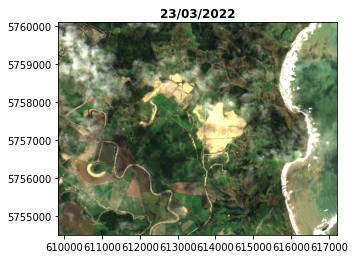

In [10]:
from matplotlib import gridspec
import matplotlib as mpl

# compute the number of rows and columns
n_plots = len(images)
n_cols = int(np.sqrt(n_plots))
n_rows = int(np.ceil(n_plots / n_cols))

# setup the plot
scale = max(n_cols, n_rows)
fig = plt.figure(figsize=(5 * scale, 5 * scale))
grid = gridspec.GridSpec(n_rows, n_cols, fig, wspace=0.4)

# iterate through each subplot and plot each image
for i in range(n_plots):
    ax = fig.add_subplot(grid[i])
    show(images[i]['rgb'],
                        transform=images[i]['transform_window'], 
                        ax=ax,  
                        title = images[i]['date'] 
                       )

for ax in fig.get_axes():
    ax.ticklabel_format(style ='plain') # show full y-axis labels

## Extract The Water Polygons
Now we have the MNDWI calcualted, we will use this to extract polygons representing pixels above a specified MNDWI value

### Set User Defined Thresholds
#### MNDWI Threshold
A pixel with a NDWI value greater than zero is generally considered water. However, multispectral images acquired by different satellite platforms at different regions and different times of year always have different characteristics

For this reason it is recommended tuning the below `mndwi_threshold` parameter for your image until the most desirable results are achieved. 


<img style="float: left;" src="images/user_var.png" width="170">

In [11]:
mndwi_threshold = 0.01 # Changing values between -1 & 1 will alter the sensitivity and number of pixels classified as water

### Mask the MNDWI image and extract water Polygons
Below:
* The MNDWI image is masked using the `mndwi_threshold`
* The mask is converted to water polygons 
* Water polygons and the Sentinel-2 images are exported to the output_directory

In [12]:
import geopandas as gpd
from shapely.geometry import shape
from rasterio import features # TODO move
sieve_threshold = 10

for image in images:
    # Mask out all values below the mndwi threshold (these are not water)
    water_mask = np.ma.masked_less(image['mndwi'], mndwi_threshold)

    # Extract the polygons from the mask
    water_polygons = rasterio.features.shapes(source=water_mask.astype('uint8'),
                                       transform=image['transform_window'],
                                       )

    # Add all polygons to the list
    water_polygons = list(water_polygons)

    # Extract the polygon coordinates and values from the list
    polygons = [polygon for polygon, value in water_polygons]
    values = [str(int(value)) for polygon, value in water_polygons]

    # Convert polygons into a shapely.shape
    polygons = [shape(polygon) for polygon in polygons]

    # Create a geopandas dataframe populated with the polygon shapes
    water_geodataframe = gpd.GeoDataFrame({'is_water': values,
                           'geometry':polygons},
                           crs= image['src_crs'])



    # Dissolve all records into two records. is water / is not water
    is_water = water_geodataframe.dissolve(by='is_water')

    # Select only the water records  
    water = is_water.query("is_water=='0'")

    
    # Export the polygons 
    water.to_file(os.path.join(output_directory, f"water_mndwi_{image['image_id']}.shp"))
                  
    # Export the accompanying Sentinel-2 image 
    export_raster(image)
    
    # Export working steps if desired 
    image['water']=water
    image['water_mask']=water_mask
    if len(water.area) == 1:
        image['area']=water.area[0]/1000000 # in km2
    else:
        image['area']=0

## Plot the Water Extraction Steps
This adds transparency to the above steps and aides rapid fine tuning such as via the`mndwi_threshold` parameter

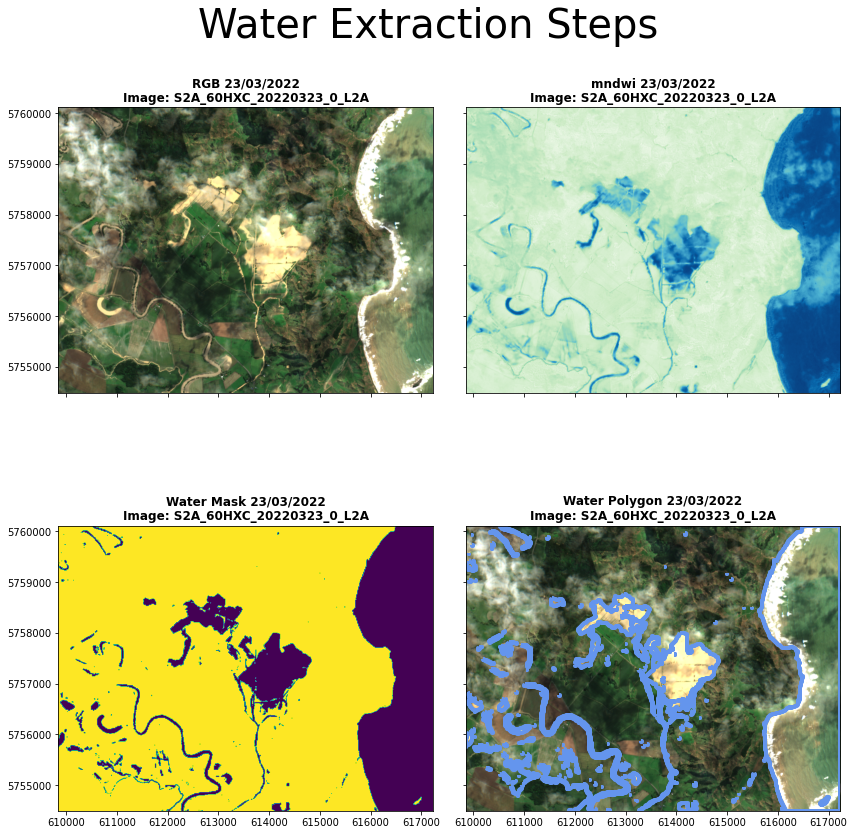

In [13]:

for image in images:
    fig, axs = plt.subplots(2, 2, figsize=(12,12))

    show(image['rgb'],
                transform=image['transform_window'], 
                ax=axs[0, 0],  
                title = f"RGB {image['date']}\nImage: {image['image_id']}"

               )

    show(image['mndwi'],
                transform=image['transform_window'], 
                ax=axs[0, 1],  
                title = f"mndwi {image['date']}\nImage: {image['image_id']}",
                cmap="GnBu"


               )

    show(image['water_mask'].mask,
                transform=image['transform_window'], 
                ax=axs[1, 0],  
                title = f"Water Mask {image['date']}\nImage: {image['image_id']}",
               )


    show(image['rgb'], 
                transform=image['transform_window'], 
                ax=axs[1,1],
                title = f"Water Polygon {image['date']}\nImage: {image['image_id']}",
             )
    image['water'].boundary.plot(ax=axs[1,1], color='cornflowerblue', linewidth=4)

    fig.suptitle('Water Extraction Steps', fontsize=40)

    for ax in fig.get_axes():
        ax.label_outer()
        ax.ticklabel_format(style ='plain') # show full y-coords
    fig.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.2)
    
    
    fig.savefig(os.path.join(output_directory, f"water_extraction_steps_{image['image_id']}.png"),
                facecolor='white')


## Further Development / Building on MVP
* Add a sieve function to remove water/nonwater features under a specified threshold  
* Analysis a baseline image and perform diff'ing to indicate flood waters as opposed to just water in general
* Cloud masking could be introduced 
* Some may find having the MNDWI and Mask images exported for use in a GIS useful. 
* If the bounding box is outside the COG extent a white boarder is attached to the image. This should be removed are transparent  

